In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
from statsmodels.stats.libqsturng import qsturng
import Orange
import itertools

Read cross-validation output for a given metric.

In [3]:
def read(how, date='20150831'):
    return pd.read_csv('../output/{}/collection/results/crossvalidation_{}_raw_ie.csv'.format(date, how))

We'll use 7 different metrics for cross-validation.

In [4]:
#metrics = ['rmse', 'me', 'mae', 'xe', 'ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']
metrics = ['ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']

Create a dataframe from the output with given columns.

In [5]:
def load(columns, date='20150831'):
    return pd.concat([read(m, date) for m in metrics]).set_index(['how', 'title', 'seq'])[columns]

In [6]:
def load2(columns, date='20150831'):
    df = pd.concat([read(m, date) for m in metrics])
    df['group'] = (df.seq / 5).astype(int)
    return df.set_index(['how', 'title', 'group'])[columns]

Default functions (`load` and `rank`) treat cross-validation samples indepenently, whereas variant functions (`load2` and `rank2`) treat them as replicates.

We'll test 3 scenarios:
1. Between individual models
2. Individual models vs. an ensemble (EN)
3. Between ensemble models.

In [7]:
individuals = ['GD', 'CF', 'Beta', 'DTS']
individuals_with_ensemble = individuals + ['EN']
ensembles = ['EN', 'EN.d', 'EN.d1', 'EN.dr', 'EN.ef', 'EN.ef1', 'EN.m', 'EN.r']

Here is a part of the dataframe for the second scenario.

In [8]:
load(individuals_with_ensemble).head()

GD         CF      Beta       DTS         EN
how title     seq                                                     
EF  cherry_dc 0     0.839466   0.669708  0.902769  0.939032   0.910893
              1     0.501785   0.249883  0.709531  0.742803   0.845170
              2     0.307813   0.034068  0.522499  0.756944   0.572903
              3     0.403007  -0.212274 -0.086853 -2.660028   0.008930
              4   -17.483073 -10.821832 -9.009766 -9.584418 -11.237047

In [9]:
load(ensembles, '20150927').head()

EN       EN.d      EN.d1      EN.dr      EN.ef  \
how title     seq                                                          
EF  cherry_dc 0     0.910893   0.911419   0.912351   0.912555   0.913464   
              1     0.845170   0.843215   0.841699   0.833911   0.810207   
              2     0.572903   0.575148   0.580564   0.582542   0.585091   
              3     0.008930  -0.007455  -0.044846  -0.046832  -0.065702   
              4   -11.237047 -11.215436 -11.173837 -11.205125 -11.190951   

                      EN.ef1       EN.m       EN.r  
how title     seq                                   
EF  cherry_dc 0     0.915470   0.912689   0.913280  
              1     0.795856   0.839684   0.838685  
              2     0.598955   0.581601   0.585024  
              3    -0.170891  -0.053519  -0.076787  
              4   -11.154400 -11.153176 -11.132369

In [10]:
load2(ensembles, '20150927').head()

EN       EN.d      EN.d1      EN.dr      EN.ef  \
how title     group                                                          
EF  cherry_dc 0       0.910893   0.911419   0.912351   0.912555   0.913464   
              0       0.845170   0.843215   0.841699   0.833911   0.810207   
              0       0.572903   0.575148   0.580564   0.582542   0.585091   
              0       0.008930  -0.007455  -0.044846  -0.046832  -0.065702   
              0     -11.237047 -11.215436 -11.173837 -11.205125 -11.190951   

                        EN.ef1       EN.m       EN.r  
how title     group                                   
EF  cherry_dc 0       0.915470   0.912689   0.913280  
              0       0.795856   0.839684   0.838685  
              0       0.598955   0.581601   0.585024  
              0      -0.170891  -0.053519  -0.076787  
              0     -11.154400 -11.153176 -11.132369

Generate a rank out of the dataframe.

In [11]:
def rank(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1]).mean()

In [12]:
def rank2(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1,2]).mean()

Here is a part of the generated ranks for the second scenario.

In [13]:
rank(load(individuals_with_ensemble)).head()

GD        CF      Beta       DTS        EN
how title                                                                
D   apple_kearneysville  3.072727  2.954545  3.177273  3.331818  2.463636
    cherry_dc            3.650000  3.350000  3.100000  2.550000  2.350000
    cherry_korea         3.323077  2.923077  3.230769  3.000000  2.523077
    peach_korea          3.328000  2.714000  3.460000  2.968000  2.530000
    pear_korea           3.220000  2.678000  3.320000  3.248000  2.534000

In [14]:
rank(load(ensembles, '20150927')).head()

EN      EN.d     EN.d1     EN.dr     EN.ef  \
how title                                                                
D   apple_kearneysville  4.400  4.336364  4.427273  4.836364  4.754545   
    cherry_dc            4.150  4.250000  4.450000  4.550000  4.550000   
    cherry_korea         4.400  4.430769  4.323077  4.415385  4.800000   
    peach_korea          4.884  4.616000  4.364000  4.868000  4.568000   
    pear_korea           4.616  4.480000  4.148000  4.704000  4.910000   

                           EN.ef1      EN.m      EN.r  
how title                                              
D   apple_kearneysville  4.945455  4.081818  4.218182  
    cherry_dc            4.850000  4.350000  4.850000  
    cherry_korea         4.784615  4.384615  4.461538  
    peach_korea          4.380000  4.196000  4.124000  
    pear_korea           4.606000  4.372000  4.164000

In [15]:
rank2(load2(individuals_with_ensemble)).head()

GD   CF  Beta  DTS   EN
how title               group                          
D   apple_kearneysville 0      3.2  2.6   3.8  3.4  2.0
                        1      4.0  1.4   3.6  3.8  2.2
                        2      3.0  2.8   3.2  3.8  2.2
                        3      3.0  3.2   3.0  3.2  2.6
                        4      3.2  2.4   3.2  3.6  2.6

Now we have 3 rank dataframes for each scenario.

In [16]:
rii = rank(load(individuals))
rie = rank(load(individuals_with_ensemble))
ree = rank(load(ensembles, '20150927'))

In [17]:
#rii.to_csv('rii.csv')
#rie.to_csv('rie.csv')
#ree.to_csv('ree.csv')

In [18]:
rii2 = rank2(load2(individuals))
rie2 = rank2(load2(individuals_with_ensemble))
ree2 = rank2(load2(ensembles, '20150927'))

Conduct Friedman test on the rank dataframe.

In [19]:
def friedman(rdf, how):
    return st.friedmanchisquare(*rdf.loc[how].as_matrix().T)

In [20]:
def friedmans(rdf):
    return pd.DataFrame({h: friedman(rdf, h) for h in hows}, index=['statistic', 'pvalue'])

Friedman test over individual models for Willmot's refined index of agreement (Dr) turns out to be non-significant (p=0.08).

In [21]:
friedman(rii, 'DR')

FriedmanchisquareResult(statistic=6.8400000000000034, pvalue=0.077176194457173594)

In [22]:
friedman(rii2, 'DR')

FriedmanchisquareResult(statistic=24.07574598316755, pvalue=2.4086705884416904e-05)

On the other hand, Friedman test over individuals with an ensemble model turns out to be significant (p=0.01) that there is a difference between models, in this case, due to the just added ensemble model.

In [23]:
friedman(rie, 'DR')

FriedmanchisquareResult(statistic=13.760000000000005, pvalue=0.0081017750759768518)

In [24]:
friedman(rie2, 'DR')

FriedmanchisquareResult(statistic=128.21878536401354, pvalue=9.3602654344527026e-27)

Meanwhile, Friedman test over different ensemble models turns out to be highly non-significant (p=0.65), so we can't tell there is a difference in performance between them.

In [25]:
friedman(ree, 'DR')

FriedmanchisquareResult(statistic=7.1999999999999886, pvalue=0.40835740822481481)

In [26]:
friedman(ree2, 'DR')

FriedmanchisquareResult(statistic=14.021714083134082, pvalue=0.05079649243325713)

Here is a summary over all metrics.

Friedman tests over individual models. They are all non-significant at p=0.05.

In [27]:
hows = rii.index.levels[0]
hows

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')

In [28]:
friedmans(rii)

,D,D1,DR,EF,EF1,M,R
statistic,5.880000,7.163265,6.840000,6.918367,6.840000,4.469388,6.36000
pvalue,0.117597,0.066872,0.077176,0.074546,0.077176,0.215037,0.09535


In [29]:
friedmans(rii2)

,D,D1,DR,EF,EF1,M,R
statistic,3.444915e+01,12.090069,24.075746,3.249420e+01,24.075746,3.108333e+01,17.419954
pvalue,1.592538e-07,0.007081,0.000024,4.117313e-07,0.000024,8.163877e-07,0.000579


In [30]:
friedmans(rank2(load2(['GD', 'CF', 'Beta'])))

,D,D1,DR,EF,EF1,M,R
statistic,3.114919e+01,11.143418,2.521569,1.821359,2.521569,2.983626e+01,18.003945
pvalue,1.722021e-07,0.003804,0.283432,0.402251,0.283432,3.320007e-07,0.000123


Friedman tests over individual models with an ensemble model. They are all significant at p=0.01.

In [31]:
friedmans(rie)

,D,D1,DR,EF,EF1,M,R
statistic,13.920000,14.666667,13.760000,13.920000,13.760000,13.373737,13.120000
pvalue,0.007555,0.005445,0.008102,0.007555,0.008102,0.009587,0.010704


In [32]:
friedmans(rie2)

,D,D1,DR,EF,EF1,M,R
statistic,1.125190e+02,7.076144e+01,1.282188e+02,1.269040e+02,1.282188e+02,1.067989e+02,8.961059e+01
pvalue,2.111770e-23,1.567547e-14,9.360265e-27,1.788058e-26,9.360265e-27,3.503479e-22,1.593031e-18


Friedman test over ensemble models. Most of them are highly non-significant, but there are a couple that indicates significance.

In [33]:
friedmans(ree)

,D,D1,DR,EF,EF1,M,R
statistic,15.808612,10.174224,7.200000,4.014706,7.200000,13.340580,9.333333
pvalue,0.026924,0.178913,0.408357,0.778082,0.408357,0.064232,0.229602


In [34]:
friedmans(ree2)

,D,D1,DR,EF,EF1,M,R
statistic,35.380206,13.066667,14.021714,8.301286,14.021714,28.188202,18.832125
pvalue,0.000009,0.070501,0.050796,0.306778,0.050796,0.000203,0.008730


Look at the difference between averaged ranks.

In [35]:
rii2.groupby(level='how').mean()

,GD,CF,Beta,DTS
how,,,,
D,2.572993,2.263504,2.658394,2.505109
D1,2.548175,2.337226,2.637226,2.477372
DR,2.541606,2.583212,2.642336,2.232847
EF,2.558029,2.611679,2.630292,2.200000
EF1,2.537044,2.588321,2.646168,2.228467
M,2.605109,2.238686,2.637956,2.518248
R,2.602920,2.301460,2.594161,2.501460


In [36]:
rii2.mean(axis=0).sort_values()

DTS     2.380501
CF      2.417727
GD      2.566554
Beta    2.635219
dtype: float64

Calculate critial difference for Nemenyi test.

In [37]:
def critical_value(p, k):
    return qsturng(1-p, k, np.inf) / np.sqrt(2)

def critical_difference(p, k, n):
    return critical_value(p, k) * np.sqrt((k*(k+1)) / (6*n))

In [38]:
critical_difference(0.05, 4, 5)

2.0975924614902377

In [39]:
critical_difference(0.05, 5, 5)

2.7277508838690383

In [40]:
critical_difference(0.05, 8, 5)

4.6953889282071719

In [41]:
critical_difference(0.05, 4, 137)

0.40072444135775453

In [42]:
critical_difference(0.10, 4, 137)

0.35739849198748025

In [43]:
critical_difference(0.05, 5, 137)

0.52111001978189975

In [44]:
critical_difference(0.05, 8, 137)

0.89700794589834176

In [45]:
def plot_ranks(rdf, how, p=0.05, mark=None, lowv=None, highv=None, **kwargs):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    cd = critical_difference(p, len(s), len(df))
    Orange.evaluation.graph_ranks(s, s.index, cd, mark, lowv=lowv, highv=highv, **kwargs)

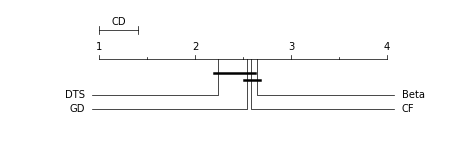

In [46]:
plot_ranks(rii2, 'DR')

In [47]:
def plot_ranks_all(rdf, p=0.05, mark=None, lowv=None, highv=None, **kwargs):
    hows = rdf.index.levels[0]
    print(hows)
    for how in hows:
        plot_ranks(rdf, how, p, mark, lowv, highv, **kwargs)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


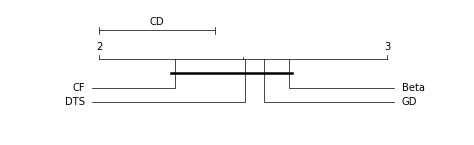

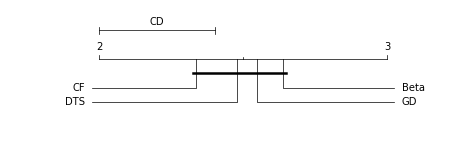

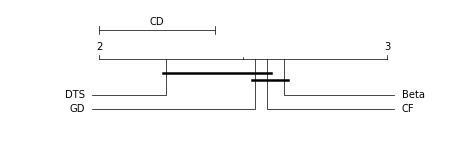

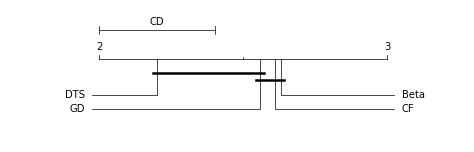

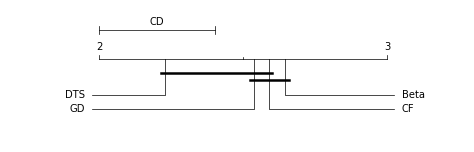

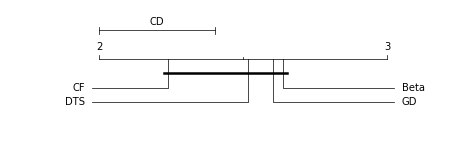

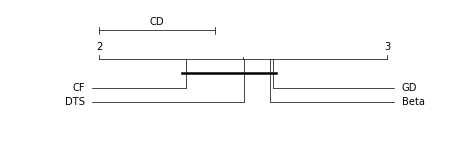

In [48]:
plot_ranks_all(rii2, lowv=2, highv=3)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


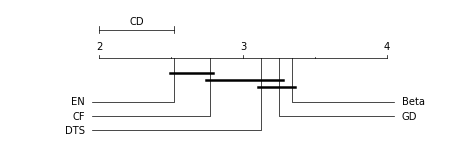

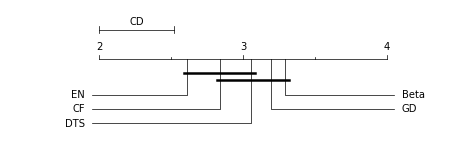

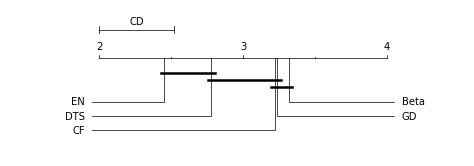

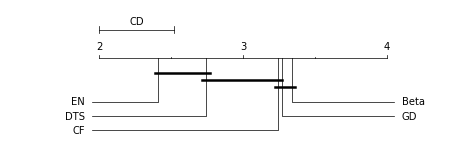

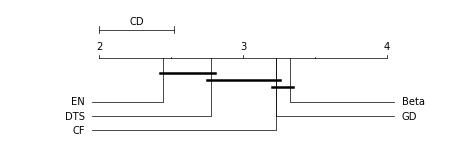

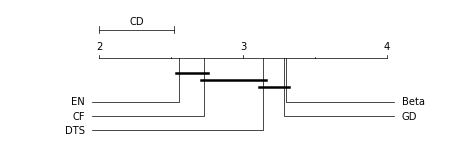

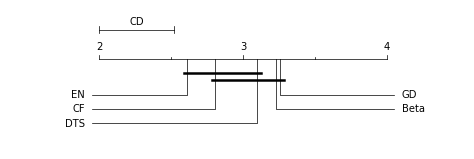

In [49]:
plot_ranks_all(rie2, lowv=2, highv=4)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


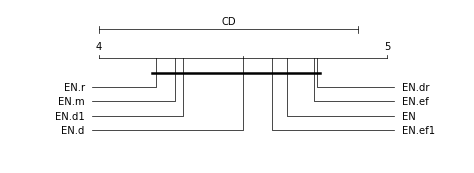

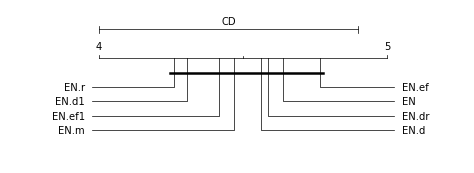

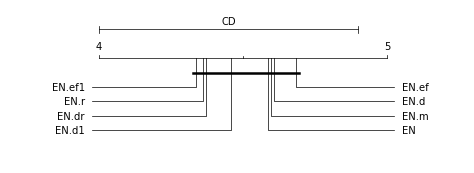

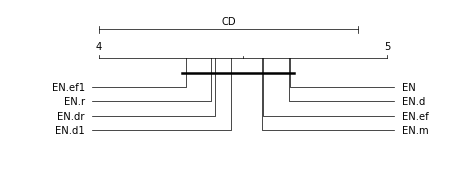

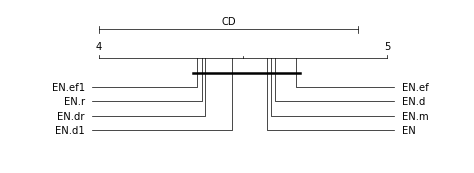

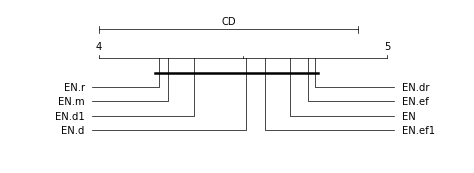

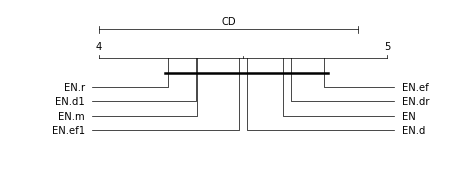

In [50]:
plot_ranks_all(ree2, lowv=4, highv=5)

Implement Nemenyi test.

In [51]:
def nemenyi(rdf, how, p=0.05, boolean=True):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    C = list(itertools.combinations(s.index, 2))
    cd = critical_difference(p, len(s), len(df))
    if boolean:
        return pd.Series({"{}-{}".format(b, a): abs(s[b] - s[a]) > cd for (a, b) in C})
    else:
        r = pd.Series({"{}-{}".format(b, a): s[b] - s[a] for (a, b) in C})
        r['critical difference'] = cd
        return r

In [52]:
def nemenyis(rdf, p=0.05, boolean=True):
    return pd.DataFrame({h: nemenyi(rdf, h, p, boolean) for h in hows})

In [53]:
nemenyi(rii2, 'DR')

Beta-CF     False
Beta-GD     False
CF-GD       False
DTS-Beta     True
DTS-CF      False
DTS-GD      False
dtype: bool

In [54]:
nemenyi(rii2, 'DR', boolean=False)

Beta-CF                0.059124
Beta-GD                0.100730
CF-GD                  0.041606
DTS-Beta              -0.409489
DTS-CF                -0.350365
DTS-GD                -0.308759
critical difference    0.400724
dtype: float64

In [55]:
nemenyis(rii2, p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,True,True,True,False,False
DTS-CF,False,False,False,True,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [56]:
nemenyis(rii2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
Beta-CF,0.394891,0.300000,0.059124,0.018613,0.057847,0.399270,0.292701
Beta-GD,0.085401,0.089051,0.100730,0.072263,0.109124,0.032847,-0.008759
CF-GD,-0.309489,-0.210949,0.041606,0.053650,0.051277,-0.366423,-0.301460
DTS-Beta,-0.153285,-0.159854,-0.409489,-0.430292,-0.417701,-0.119708,-0.092701
DTS-CF,0.241606,0.140146,-0.350365,-0.411679,-0.359854,0.279562,0.200000
DTS-GD,-0.067883,-0.070803,-0.308759,-0.358029,-0.308577,-0.086861,-0.101460
critical difference,0.400724,0.400724,0.400724,0.400724,0.400724,0.400724,0.400724


DR metric indicated that DTS was significantly better than Beta. EF metric indicated that DTS was significantly better than CF and Beta. But, no metric could show significant difference between DTS and GD. Also, there was no significance reported by other five metrics at all. All tests were conducted at p=0.05 level.

In [57]:
nemenyis(rii2, p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,True,False,False,False,False,True,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,True,False
DTS-Beta,False,False,True,True,True,False,False
DTS-CF,False,False,False,True,True,False,False
DTS-GD,False,False,False,True,False,False,False


In [58]:
nemenyis(rii2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
Beta-CF,0.394891,0.300000,0.059124,0.018613,0.057847,0.399270,0.292701
Beta-GD,0.085401,0.089051,0.100730,0.072263,0.109124,0.032847,-0.008759
CF-GD,-0.309489,-0.210949,0.041606,0.053650,0.051277,-0.366423,-0.301460
DTS-Beta,-0.153285,-0.159854,-0.409489,-0.430292,-0.417701,-0.119708,-0.092701
DTS-CF,0.241606,0.140146,-0.350365,-0.411679,-0.359854,0.279562,0.200000
DTS-GD,-0.067883,-0.070803,-0.308759,-0.358029,-0.308577,-0.086861,-0.101460
critical difference,0.357398,0.357398,0.357398,0.357398,0.357398,0.357398,0.357398


The ensemble model (EN) was significantly better than Beta and GD in all metrics. Three metrics, DR, EF, and EF1, reported significant difference against CF. Two metrics, D and M, reported significant difference against DTS. (p=0.05).

In [59]:
nemenyis(rie2, p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,True,False,False,False,False,True,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,True,False
DTS-Beta,False,False,True,True,True,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,True,False,False,False
EN-Beta,True,True,True,True,True,True,True
EN-CF,False,False,True,True,True,False,False
EN-DTS,True,False,False,False,False,True,False
EN-GD,True,True,True,True,True,True,True


In [60]:
nemenyis(rie2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
Beta-CF,0.567883,0.451095,0.098540,0.092701,0.096168,0.565693,0.421168
Beta-GD,0.084672,0.097080,0.081752,0.070438,0.093066,0.009489,-0.028467
CF-GD,-0.483212,-0.354015,-0.016788,-0.022263,-0.003102,-0.556204,-0.449635
DTS-Beta,-0.210949,-0.237956,-0.536496,-0.594161,-0.547263,-0.160584,-0.129927
DTS-CF,0.356934,0.213139,-0.437956,-0.501460,-0.451095,0.405109,0.291241
DTS-GD,-0.126277,-0.140876,-0.454745,-0.523723,-0.454197,-0.151095,-0.158394
EN-Beta,-0.818978,-0.681022,-0.863504,-0.925182,-0.879380,-0.738686,-0.616058
EN-CF,-0.251095,-0.229927,-0.764964,-0.832482,-0.783212,-0.172993,-0.194891
EN-DTS,-0.608029,-0.443066,-0.327007,-0.331022,-0.332117,-0.578102,-0.486131
EN-GD,-0.734307,-0.583942,-0.781752,-0.854745,-0.786314,-0.729197,-0.644526


In [61]:
nemenyis(rie2, p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,True,False,False,False,False,True,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,True,False,False,False,False,True,False
DTS-Beta,False,False,True,True,True,False,False
DTS-CF,False,False,False,True,False,False,False
DTS-GD,False,False,False,True,False,False,False
EN-Beta,True,True,True,True,True,True,True
EN-CF,False,False,True,True,True,False,False
EN-DTS,True,False,False,False,False,True,True
EN-GD,True,True,True,True,True,True,True


In [62]:
nemenyis(rie2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
Beta-CF,0.567883,0.451095,0.098540,0.092701,0.096168,0.565693,0.421168
Beta-GD,0.084672,0.097080,0.081752,0.070438,0.093066,0.009489,-0.028467
CF-GD,-0.483212,-0.354015,-0.016788,-0.022263,-0.003102,-0.556204,-0.449635
DTS-Beta,-0.210949,-0.237956,-0.536496,-0.594161,-0.547263,-0.160584,-0.129927
DTS-CF,0.356934,0.213139,-0.437956,-0.501460,-0.451095,0.405109,0.291241
DTS-GD,-0.126277,-0.140876,-0.454745,-0.523723,-0.454197,-0.151095,-0.158394
EN-Beta,-0.818978,-0.681022,-0.863504,-0.925182,-0.879380,-0.738686,-0.616058
EN-CF,-0.251095,-0.229927,-0.764964,-0.832482,-0.783212,-0.172993,-0.194891
EN-DTS,-0.608029,-0.443066,-0.327007,-0.331022,-0.332117,-0.578102,-0.486131
EN-GD,-0.734307,-0.583942,-0.781752,-0.854745,-0.786314,-0.729197,-0.644526


There was no single incidence reported by all metrics that any ensemble model significantly outperformed (at p=0.05).

In [63]:
nemenyis(ree2, p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


In [64]:
nemenyis(ree2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,-0.153285,-0.076642,0.022628,-0.006569,0.027372,-0.152555,-0.125547
EN.d1-EN,-0.359124,-0.334307,-0.125547,-0.205474,-0.121533,-0.332847,-0.302190
EN.d1-EN.d,-0.205839,-0.257664,-0.148175,-0.198905,-0.148905,-0.180292,-0.176642
EN.dr-EN,0.103650,-0.052555,-0.214599,-0.263139,-0.214234,0.085401,0.027737
EN.dr-EN.d,0.256934,0.024088,-0.237226,-0.256569,-0.241606,0.237956,0.153285
EN.dr-EN.d1,0.462774,0.281752,-0.089051,-0.057664,-0.092701,0.418248,0.329927
EN.ef-EN,0.092701,0.126277,0.097810,-0.096715,0.102555,0.062774,0.143066
EN.ef-EN.d,0.245985,0.202920,0.075182,-0.090146,0.075182,0.215328,0.268613
EN.ef-EN.d1,0.451825,0.460584,0.223358,0.108759,0.224088,0.395620,0.445255
EN.ef-EN.dr,-0.010949,0.178832,0.312409,0.166423,0.316788,-0.022628,0.115328


In [65]:
nemenyis(ree2, p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


In [66]:
nemenyis(ree2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,-0.153285,-0.076642,0.022628,-0.006569,0.027372,-0.152555,-0.125547
EN.d1-EN,-0.359124,-0.334307,-0.125547,-0.205474,-0.121533,-0.332847,-0.302190
EN.d1-EN.d,-0.205839,-0.257664,-0.148175,-0.198905,-0.148905,-0.180292,-0.176642
EN.dr-EN,0.103650,-0.052555,-0.214599,-0.263139,-0.214234,0.085401,0.027737
EN.dr-EN.d,0.256934,0.024088,-0.237226,-0.256569,-0.241606,0.237956,0.153285
EN.dr-EN.d1,0.462774,0.281752,-0.089051,-0.057664,-0.092701,0.418248,0.329927
EN.ef-EN,0.092701,0.126277,0.097810,-0.096715,0.102555,0.062774,0.143066
EN.ef-EN.d,0.245985,0.202920,0.075182,-0.090146,0.075182,0.215328,0.268613
EN.ef-EN.d1,0.451825,0.460584,0.223358,0.108759,0.224088,0.395620,0.445255
EN.ef-EN.dr,-0.010949,0.178832,0.312409,0.166423,0.316788,-0.022628,0.115328


Test each dataset separately.

In [67]:
def extract(rdf, title):
    return rdf.xs(title, level='title')

In [68]:
def friedman2(rdf, how):
    titles = rdf.index.get_level_values('title').unique()
    return {t: friedman(extract(rdf, t), how) for t in titles}

In [69]:
pd.DataFrame({h: friedman2(rii2, h) for h in hows})

,D,D1,DR,EF,EF1,M,R
apple_kearneysville,"(5.66666666667, 0.129003061437)","(1.79126213592, 0.616838236571)","(9.53773584906, 0.0229332844692)","(4.35294117647, 0.225788700034)","(9.53773584906, 0.0229332844692)","(2.20673076923, 0.530623836663)","(1.25714285714, 0.739334193722)"
cherry_dc,"(3.70588235294, 0.295025024349)","(2.29411764706, 0.513648746235)","(3.94736842105, 0.267203761418)","(3.63157894737, 0.304093440989)","(3.94736842105, 0.267203761418)","(3.16666666667, 0.366635384075)","(3.31578947368, 0.345451083106)"
cherry_korea,"(1.31404958678, 0.725799597406)","(2.49579831933, 0.476050899724)","(6.625, 0.0848610422919)","(3.8275862069, 0.280693656752)","(6.625, 0.0848610422919)","(1.64754098361, 0.648658898129)","(3.43220338983, 0.329662148132)"
peach_korea,"(14.8411016949, 0.00195759851957)","(4.16108786611, 0.24458671755)","(11.3158995816, 0.0101347658224)","(12.5849056604, 0.0056259340875)","(11.3158995816, 0.0101347658224)","(15.2021052632, 0.00165183315439)","(5.18697478992, 0.158606866304)"
pear_korea,"(19.5405405405, 0.000211329620897)","(10.6972860125, 0.0134806120786)","(5.69246861925, 0.127569488839)","(14.8113207547, 0.00198519769795)","(5.69246861925, 0.127569488839)","(17.3594080338, 0.000596081392676)","(16.4489361702, 0.000917275258208)"


#### Kearneysville Apple

In [70]:
friedmans(extract(rii2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,5.666667,1.791262,9.537736,4.352941,9.537736,2.206731,1.257143
pvalue,0.129003,0.616838,0.022933,0.225789,0.022933,0.530624,0.739334


In [71]:
nemenyis(extract(rii2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [72]:
friedmans(extract(rie2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,17.81733,13.803738,30.420561,19.168224,30.420561,15.051643,18.932084
pvalue,0.00134,0.007949,0.000004,0.000728,0.000004,0.004595,0.000810


In [73]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [74]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,True,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [75]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.20)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,True,True,False,False
EN-CF,False,False,True,True,True,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [76]:
friedmans(extract(ree2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,6.458882,8.478548,5.935036,5.908686,5.935036,7.814043,1.170718
pvalue,0.487302,0.292291,0.547355,0.550451,0.547355,0.349277,0.991586


In [77]:
nemenyis(extract(ree2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### DC Cherry

In [78]:
friedmans(extract(rii2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,3.705882,2.294118,3.947368,3.631579,3.947368,3.166667,3.315789
pvalue,0.295025,0.513649,0.267204,0.304093,0.267204,0.366635,0.345451


In [79]:
nemenyis(extract(rii2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [80]:
friedmans(extract(rie2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,7.282051,3.351351,6.526316,6.666667,6.526316,6.800000,6.666667
pvalue,0.121713,0.500837,0.163140,0.154587,0.163140,0.146842,0.154587


In [81]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [82]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [83]:
friedmans(extract(ree2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,3.787671,9.285714,7.838323,1.408537,7.838323,2.305389,11.778443
pvalue,0.803883,0.232789,0.347066,0.985308,0.347066,0.941025,0.108084


In [84]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


In [85]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Cherry

In [86]:
friedmans(extract(rii2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,1.31405,2.495798,6.625000,3.827586,6.625000,1.647541,3.432203
pvalue,0.72580,0.476051,0.084861,0.280694,0.084861,0.648659,0.329662


In [87]:
nemenyis(extract(rii2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [88]:
friedmans(extract(rie2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,10.032520,8.208000,18.532258,18.258065,18.532258,8.000000,9.837398
pvalue,0.039883,0.084249,0.000971,0.001099,0.000971,0.091578,0.043258


In [89]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [90]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,False,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [91]:
friedmans(extract(ree2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,6.500469,7.386704,6.870370,3.206157,6.870370,9.155367,10.375933
pvalue,0.482671,0.389756,0.442501,0.865299,0.442501,0.241693,0.168252


In [92]:
nemenyis(extract(ree2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Peach

In [93]:
friedmans(extract(rii2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,14.841102,4.161088,11.315900,12.584906,11.315900,15.202105,5.186975
pvalue,0.001958,0.244587,0.010135,0.005626,0.010135,0.001652,0.158607


In [94]:
nemenyis(extract(rii2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [95]:
friedmans(extract(rie2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,4.171488e+01,24.551867,4.342324e+01,4.187384e+01,4.342324e+01,3.779482e+01,24.935118
pvalue,1.911301e-08,0.000062,8.453024e-09,1.771689e-08,8.453024e-09,1.235253e-07,0.000052


In [96]:
nemenyis(extract(rie2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,True,False,True,True,True,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,True,False,False,False


In [97]:
nemenyis(extract(rie2, 'peach_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,True,False,True,True,True,True,False
EN-CF,False,False,True,True,True,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,True,False,True,True,True,True,False


In [98]:
friedmans(extract(ree2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,17.735245,3.231944,5.070014,15.867683,5.070014,16.403010,10.245763
pvalue,0.013223,0.862749,0.651419,0.026353,0.651419,0.021679,0.175069


In [99]:
nemenyis(extract(ree2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Pear

In [100]:
friedmans(extract(rii2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,19.540541,10.697286,5.692469,14.811321,5.692469,17.359408,16.448936
pvalue,0.000211,0.013481,0.127569,0.001985,0.127569,0.000596,0.000917


In [101]:
nemenyis(extract(rii2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [102]:
nemenyis(extract(rii2, 'pear_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False


In [103]:
friedmans(extract(rie2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,4.992791e+01,30.277433,4.652415e+01,5.100000e+01,4.652415e+01,5.053222e+01,4.003326e+01
pvalue,3.738205e-10,0.000004,1.915741e-09,2.232218e-10,1.915741e-09,2.795520e-10,4.260399e-08


In [104]:
nemenyis(extract(rie2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,False,False,False,True,False,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,False,False,False,False,False


In [105]:
nemenyis(extract(rie2, 'pear_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False
CF-GD,False,False,False,False,False,False,False
DTS-Beta,False,False,False,False,False,False,False
DTS-CF,False,False,False,False,False,False,False
DTS-GD,False,False,False,False,False,False,False
EN-Beta,True,False,True,True,True,False,False
EN-CF,False,False,False,False,False,False,False
EN-DTS,False,False,False,False,False,False,False
EN-GD,False,False,True,True,True,False,False


In [106]:
friedmans(extract(ree2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,18.100976,16.564911,15.063767,12.258944,15.063767,17.549081,11.218566
pvalue,0.011523,0.020428,0.035191,0.092359,0.035191,0.014179,0.129365


In [107]:
nemenyis(extract(ree2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False
